In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.stats as stats
from scipy.io import loadmat
from spectral import *
from functions import *
from scipy.io import loadmat
import multiprocessing
import warnings
import time
import math

/usr/local/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [22]:
order_list = [[5,5]]
max_order = [7,7]
[p_max, q_max] = max_order
nrep = 100
SEED = 2024

cov_loc = causal_get_cov_loc(max_order)

MSE_lev_list = np.ones(len(order_list))
MSE_fast_list = np.ones(len(order_list))
MSE_OLS_list = np.ones(len(order_list))
MSE_random_list = np.ones(len(order_list))
MSE_lev_std_list = np.zeros(len(order_list))
MSE_fast_std_list = np.zeros(len(order_list))
MSE_OLS_std_list = np.zeros(len(order_list))
MSE_random_std_list = np.zeros(len(order_list))

MSE_para_lev_list = np.ones(len(order_list))
MSE_para_fast_list = np.ones(len(order_list))
MSE_para_OLS_list = np.ones(len(order_list))
MSE_para_random_list = np.ones(len(order_list))
MSE_para_lev_std_list = np.zeros(len(order_list))
MSE_para_fast_std_list = np.zeros(len(order_list))
MSE_para_OLS_std_list = np.zeros(len(order_list))
MSE_para_random_std_list = np.zeros(len(order_list))

time_lev_list = np.zeros(len(order_list))
time_fast_list = np.zeros(len(order_list))
time_OLS_list = np.zeros(len(order_list))
time_random_list = np.zeros(len(order_list))

significance_lev_list = np.zeros([len(cov_loc), nrep])
significance_fast_list = np.zeros([len(cov_loc), nrep])
significance_OLS_list = np.zeros([len(cov_loc), nrep])
significance_random_list = np.zeros([len(cov_loc), nrep])

m = 300
n = 100
subsample_size = 1000

order_num = 0
para_num_list = []

for order in order_list:
    p = order[0]
    q = order[1]
    beta = beta_generate(order, method = '3')
    beta = beta + 0.1 * ((beta > 0) - 0.5)   ### Change parameter settings here
    #beta = beta + 0.01 * ((beta > 0) - 0.5)
    beta[p,q] = 0
    phi = beta_to_phi(beta, order)
    para_num = (p+1)*(q+1)-1
    para_num_list.append(para_num)
    print(order)

    MSE_para_lev = np.zeros(nrep)
    MSE_para_fast = np.zeros(nrep)
    MSE_para_OLS = np.zeros(nrep)
    MSE_para_random = np.zeros(nrep)

    for rep in range(nrep):

        np.random.seed(rep)
        Y = np.zeros([m,n])
        for i in range(p_max):
            Y[i,:] = 1*np.random.randn(n) + i
        for i in range(q_max):
            Y[:,i] = 1*np.random.randn(m) + i

        for i in range(p_max,m):
            for j in range(q_max,n):
                Y[i,j] = np.sum(Y[(i-p):(i+1),(j-q):(j+1)] * beta) + 0.1 * np.sum(np.random.randn(1))

        cov_loc = causal_get_cov_loc(max_order)
        MSE_lev_temp = np.ones(len(cov_loc))
        MSE_fast_temp = np.ones(len(cov_loc))
        MSE_OLS_temp = np.ones(len(cov_loc))
        MSE_random_temp = np.ones(len(cov_loc))

        MSE0 = np.mean((Y[p_max:,q_max:] - np.mean(Y[p_max:,q_max:]))**2 )
        XX = np.zeros([(m-p_max), (n-q_max),len(cov_loc)])
        i = 0
        for loc in cov_loc:
            k = loc[0]
            l = loc[1]
            XX[:,:,i] = Y[(p_max+k):(m+k), (q_max+l):(n+l)]
            i = i + 1

        start_lev = time.time()
        for l in range(len(cov_loc)-1, len(cov_loc)):
            loc = cov_loc[l]
            XX_temp = XX[:,:,:(l+1)]
            lev_temp = np.zeros([m-p_max,n-q_max])
            matrix_inv = np.linalg.inv(tensor_multiply(XX_temp, XX_temp))
            for i in range(m-p_max):
                for j in range(n-q_max):
                    lev_temp[i,j] = XX_temp[i,j,:].T @ matrix_inv @ XX_temp[i,j,:]
            phi_lev, XX_sub = two_dim_param_estimate_leverage(XX_temp, Y[p_max:,q_max:], lev_score = lev_temp, subsample_size = subsample_size, return_XX_sub = True)
            MSE_temp = MSE_calculate(XX_temp, Y[p_max:,q_max:], phi_lev)
        end_lev = time.time()
        time_lev = end_lev - start_lev
        time_lev_list[order_num] = time_lev
        ###hypothesis test
        XX_inv = np.linalg.inv(XX_sub.T @ XX_sub)
        phi_std = np.sqrt(MSE_temp * np.diag(XX_inv))
        for k in range(len(phi_lev)):
            significance_lev_list[k, rep] = 2 - 2 * stats.t.cdf(np.abs(phi_lev[k] / phi_std[k]), df = subsample_size - len(cov_loc))

        start_fast = time.time()
        leverage_score_list = causal_fast_order_selection(Y, order=max_order, subsample_size = subsample_size)
        for l in range(len(cov_loc)):
            loc = cov_loc[l]
            XX_temp = XX[:,:,:(l+1)]
            lev_temp = leverage_score_list[l]
            phi_fast, XX_sub = two_dim_param_estimate_leverage(XX_temp, Y[p_max:,q_max:], lev_score = leverage_score_list[l], subsample_size = subsample_size, return_XX_sub=True)
            MSE_temp = MSE_calculate(XX_temp, Y[p_max:,q_max:], phi_fast)
        end_fast = time.time()
        time_fast = end_fast - start_fast
        time_fast_list[order_num] = time_fast
        XX_inv = np.linalg.inv(XX_sub.T @ XX_sub)
        phi_std = np.sqrt(MSE_temp * np.diag(XX_inv))
        for k in range(len(phi_fast)):
            significance_fast_list[k, rep] = 2 - 2 * stats.t.cdf(np.abs(phi_fast[k] / phi_std[k]), df = subsample_size - len(cov_loc))

        start_OLS = time.time()
        for l in range(len(cov_loc)-1, len(cov_loc)):
            loc = cov_loc[l]
            XX_temp = XX[:,:,:(l+1)]
            phi_OLS = two_dim_param_estimate_leverage(XX_temp, Y[p_max:,q_max:]).reshape(-1)
            MSE_temp = MSE_calculate(XX_temp, Y[p_max:,q_max:], phi_OLS)
        end_OLS = time.time()
        time_OLS = end_OLS - start_OLS
        time_OLS_list[order_num] = time_OLS
        XX_inv = np.linalg.inv(tensor_multiply(XX, XX))
        phi_std = np.sqrt(MSE_temp * np.diag(XX_inv))
        for k in range(len(phi_OLS)):
            significance_OLS_list[k, rep] = 2 - 2 * stats.t.cdf(np.abs(phi_OLS[k] / phi_std[k]), df = m*n - len(cov_loc))

        start_random = time.time()
        MSE_random_temp = np.ones(len(cov_loc))
        for l in range(len(cov_loc)-1, len(cov_loc)):
            loc = cov_loc[l]
            XX_temp = XX[:,:,:(l+1)]
            phi_random, XX_sub = two_dim_param_estimate_leverage(XX_temp, Y[p_max:,q_max:], lev_score = np.ones([m-p_max,n-q_max]), subsample_size = subsample_size, return_XX_sub=True)
            MSE_temp = MSE_calculate(XX_temp, Y[p_max:,q_max:], phi_random)
        end_random = time.time()
        time_random = end_random - start_random
        time_random_list[order_num] = time_random
        XX_inv = np.linalg.inv(XX_sub.T @ XX_sub)
        phi_std = np.sqrt(MSE_temp * np.diag(XX_inv))
        for k in range(len(phi_random)):
            significance_random_list[k, rep] = 2 - 2 * stats.t.cdf(np.abs(phi_random[k] / phi_std[k]), df = subsample_size - len(cov_loc))

    MSE_para_lev_list[order_num] = np.mean(MSE_para_lev)
    MSE_para_fast_list[order_num] = np.mean(MSE_para_fast)
    MSE_para_OLS_list[order_num] = np.mean(MSE_para_OLS)
    MSE_para_random_list[order_num] = np.mean(MSE_para_random)

    MSE_para_lev_std_list[order_num] = np.std(MSE_para_lev)
    MSE_para_fast_std_list[order_num] = np.std(MSE_para_fast)
    MSE_para_OLS_std_list[order_num] = np.std(MSE_para_OLS)
    MSE_para_random_std_list[order_num] = np.std(MSE_para_random)

    order_num = order_num + 1

[5, 5]


In [24]:
cov_loc = causal_get_cov_loc(max_order)
[p_max, q_max] = max_order
significance_lev_plane = np.zeros([p_max+1, q_max+1, nrep])
significance_fast_plane = np.zeros([p_max+1, q_max+1, nrep])
significance_OLS_plane = np.zeros([p_max+1, q_max+1, nrep])
significance_random_plane = np.zeros([p_max+1, q_max+1, nrep])
for rep in range(nrep):
    for l in range(len(cov_loc)):
        significance_lev_plane[-cov_loc[l][0], -cov_loc[l][1], rep] = significance_lev_list[l, rep]
        significance_fast_plane[-cov_loc[l][0], -cov_loc[l][1], rep] = significance_fast_list[l, rep]
        significance_OLS_plane[-cov_loc[l][0], -cov_loc[l][1], rep] = significance_OLS_list[l, rep]
        significance_random_plane[-cov_loc[l][0], -cov_loc[l][1], rep] = significance_random_list[l, rep]

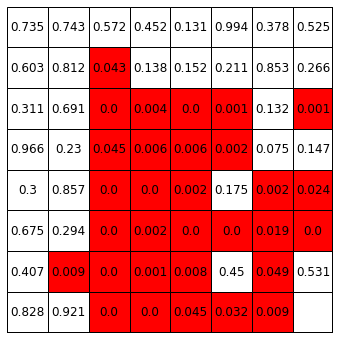

In [ ]:
rep = 0
numbers = np.arange(1, 65).reshape(8, 8)

fig, ax = plt.subplots(figsize=(6, 6))

for row in range(8):
    for col in range(8):
        rect = plt.Rectangle((7 - col, row), 1, 1, edgecolor='black', facecolor='white')
        if(row == 0 and col == 0):
            continue
        sig = significance_OLS_plane[row, col, rep]      ### Change to different method by referring to different data
        #sig = significance_lev_plane[row, col, rep]
        #sig = significance_fast_plane[row, col, rep]
        #sig = significance_random_plane[row, col, rep]

        if(sig < 0.05):
            rect = plt.Rectangle((7 - col, row), 1, 1, edgecolor='black', facecolor='red')
        ax.add_patch(rect)
        ax.text(7 - col + 0.5, row + 0.5, str(round(sig,3)),
                ha='center', va='center', fontsize=12)

ax.plot([8, 8], [0, 8], color='black', lw=2)
ax.plot([0, 8], [0, 0], color='black', lw=2)

ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
ax.set_aspect('equal')
ax.axis('off') 

plt.show()


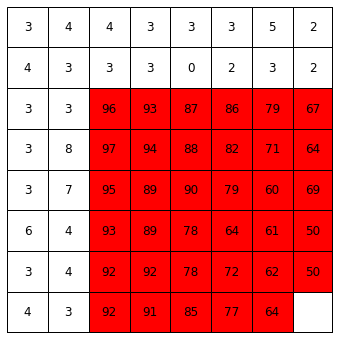

In [ ]:
rep = 5
numbers = np.arange(1, 65).reshape(8, 8)

fig, ax = plt.subplots(figsize=(6, 6))

for row in range(8):
    for col in range(8):
        rect = plt.Rectangle((7 - col, row), 1, 1, edgecolor='black', facecolor='white')
        if(row == 0 and col == 0):
            continue
        num_under_sig = np.sum(significance_OLS_plane[row, col, :] < 0.05)   ### Change to different method by referring to different data
        #num_under_sig = np.sum(significance_lev_plane[row, col, :] < 0.05)
        #num_under_sig = np.sum(significance_fast_plane[row, col, :] < 0.05)
        #num_under_sig = np.sum(significance_random_plane[row, col, :] < 0.05)
        
        if(num_under_sig > 10):
            rect = plt.Rectangle((7 - col, row), 1, 1, edgecolor='black', facecolor='red')
        ax.add_patch(rect)
        ax.text(7 - col + 0.5, row + 0.5, str(num_under_sig),
                ha='center', va='center', fontsize=12)

ax.plot([8, 8], [0, 8], color='black', lw=2)
ax.plot([0, 8], [0, 0], color='black', lw=2)

ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
ax.set_aspect('equal')
ax.axis('off')  

plt.show()

### Real Data

In [33]:
file_names = ['Airport','San_Diego']
data_dict = {}
map_dict = {}
for file_name in file_names:
    HSI = loadmat("./dataset/{}.mat".format(file_name))
    data_dict[file_name] = HSI['data']
    map_dict[file_name] = HSI['map']

In [34]:
file_names = ['San_Diego']
order_list = [[2,2]]
order = [2,2]
max_order = [3,3]
[p_max, q_max] = max_order
SEED = 2024
nrep = 1
subsample_size = 1000

cov_loc = get_cov_loc(max_order)

time_lev_list = np.zeros(len(order_list))
time_fast_list = np.zeros(len(order_list))
time_OLS_list = np.zeros(len(order_list))
time_random_list = np.zeros(len(order_list))

significance_lev_list = np.zeros([len(cov_loc), nrep])
significance_fast_list = np.zeros([len(cov_loc), nrep])
significance_OLS_list = np.zeros([len(cov_loc), nrep])
significance_random_list = np.zeros([len(cov_loc), nrep])

order_num = 0
para_num_list = []

for file_name in file_names:
    HSI = data_dict[file_name]
    img = np.mean(HSI,axis=2)
    Y = img
    [m,n] = Y.shape
    p = order[0]
    q = order[1]

    for rep in range(nrep):
        cov_loc = get_cov_loc(max_order)
        MSE_lev_temp = np.ones(len(cov_loc))
        MSE_fast_temp = np.ones(len(cov_loc))
        MSE_OLS_temp = np.ones(len(cov_loc))
        MSE_random_temp = np.ones(len(cov_loc))

        MSE0 = np.mean((Y[p_max:-p_max,q_max:-q_max] - np.mean(Y[p_max:-p_max,q_max:-q_max]))**2 )
        XX = np.zeros([(m-2*p_max), (n-2*q_max),len(cov_loc)])
        i = 0
        for loc in cov_loc:
            k = loc[0]
            l = loc[1]
            XX[:,:,i] = Y[(p_max+k):(m-p_max+k), (q_max+l):(n-q_max+l)]
            i = i + 1

        start_lev = time.time()
        for l in range(len(cov_loc)-1, len(cov_loc)):
            loc = cov_loc[l]
            XX_temp = XX[:,:,:(l+1)]
            lev_temp = np.zeros([m-2*p_max,n-2*q_max])
            matrix_inv = np.linalg.inv(tensor_multiply(XX_temp, XX_temp))
            for i in range(m-2*p_max):
                for j in range(n-2*q_max):
                    lev_temp[i,j] = XX_temp[i,j,:].T @ matrix_inv @ XX_temp[i,j,:]
            phi_lev, XX_sub = two_dim_param_estimate_leverage(XX_temp, Y[p_max:-p_max,q_max:-q_max], lev_score = lev_temp, subsample_size = subsample_size, return_XX_sub = True)
            MSE_temp = MSE_calculate(XX_temp, Y[p_max:-p_max,q_max:-q_max], phi_lev)
        end_lev = time.time()
        time_lev = end_lev - start_lev
        time_lev_list[order_num] = time_lev
        ###hypothesis test
        XX_inv = np.linalg.inv(XX_sub.T @ XX_sub)
        phi_std = np.sqrt(MSE_temp * np.diag(XX_inv))
        for k in range(len(cov_loc)):
            significance_lev_list[k, rep] = 2 - 2 * stats.t.cdf(np.abs(phi_lev[k] / phi_std[k]), df = subsample_size - len(cov_loc))

        start_fast = time.time()
        leverage_score = fast_2d_AR_leverage_score(Y, order=max_order, subsample_size = subsample_size)
        for l in range(len(cov_loc)):
            loc = cov_loc[l]
            XX_temp = XX[:,:,:(l+1)]
            lev_temp = leverage_score[p_max:-p_max, q_max:-q_max]
            phi_fast, XX_sub = two_dim_param_estimate_leverage(XX_temp, Y[p_max:-p_max,q_max:-q_max], lev_score = lev_temp, subsample_size = subsample_size, return_XX_sub=True)
            MSE_temp = MSE_calculate(XX_temp, Y[p_max:-p_max,q_max:-q_max], phi_fast)
        end_fast = time.time()
        time_fast = end_fast - start_fast
        time_fast_list[order_num] = time_fast
        XX_inv = np.linalg.inv(XX_sub.T @ XX_sub)
        phi_std = np.sqrt(MSE_temp * np.diag(XX_inv))
        for k in range(len(cov_loc)):
            significance_fast_list[k, rep] = 2 - 2 * stats.t.cdf(np.abs(phi_fast[k] / phi_std[k]), df = subsample_size - len(cov_loc))

        start_OLS = time.time()
        for l in range(len(cov_loc)-1, len(cov_loc)):
            loc = cov_loc[l]
            XX_temp = XX[:,:,:(l+1)]
            phi_OLS = two_dim_param_estimate_leverage(XX_temp, Y[p_max:-p_max,q_max:-q_max]).reshape(-1)
            MSE_temp = MSE_calculate(XX_temp, Y[p_max:-p_max,q_max:-q_max], phi_OLS)
        end_OLS = time.time()
        time_OLS = end_OLS - start_OLS
        time_OLS_list[order_num] = time_OLS
        XX_inv = np.linalg.inv(tensor_multiply(XX, XX))
        phi_std = np.sqrt(MSE_temp * np.diag(XX_inv))
        for k in range(len(cov_loc)):
            significance_OLS_list[k, rep] = 2 - 2 * stats.t.cdf(np.abs(phi_OLS[k] / phi_std[k]), df = m*n - len(cov_loc))

        start_random = time.time()
        MSE_random_temp = np.ones(len(cov_loc))
        for l in range(len(cov_loc)-1, len(cov_loc)):
            loc = cov_loc[l]
            XX_temp = XX[:,:,:(l+1)]
            phi_random, XX_sub = two_dim_param_estimate_leverage(XX_temp, Y[p_max:-p_max,q_max:-q_max], lev_score = np.ones([m-2*p_max,n-2*q_max]), subsample_size = subsample_size, return_XX_sub=True)
            MSE_temp = MSE_calculate(XX_temp, Y[p_max:-p_max,q_max:-q_max], phi_random)
        end_random = time.time()
        time_random = end_random - start_random
        time_random_list[order_num] = time_random
        XX_inv = np.linalg.inv(XX_sub.T @ XX_sub)
        phi_std = np.sqrt(MSE_temp * np.diag(XX_inv))
        for k in range(len(cov_loc)):
            significance_random_list[k, rep] = 2 - 2 * stats.t.cdf(np.abs(phi_random[k] / phi_std[k]), df = subsample_size - len(cov_loc))

In [35]:
cov_loc = get_cov_loc(max_order)
[p_max, q_max] = max_order
significance_lev_plane = np.zeros([2*p_max+1, 2*q_max+1, nrep])
significance_fast_plane = np.zeros([2*p_max+1, 2*q_max+1, nrep])
significance_OLS_plane = np.zeros([2*p_max+1, 2*q_max+1, nrep])
significance_random_plane = np.zeros([2*p_max+1, 2*q_max+1, nrep])
for rep in range(nrep):
    for l in range(len(cov_loc)):
        significance_lev_plane[-cov_loc[l][0]+p_max, -cov_loc[l][1]+q_max, rep] = significance_lev_list[l, rep]
        significance_fast_plane[-cov_loc[l][0]+p_max, -cov_loc[l][1]+q_max, rep] = significance_fast_list[l, rep]
        significance_OLS_plane[-cov_loc[l][0]+p_max, -cov_loc[l][1]+q_max, rep] = significance_OLS_list[l, rep]
        significance_random_plane[-cov_loc[l][0]+p_max, -cov_loc[l][1]+q_max, rep] = significance_random_list[l, rep]

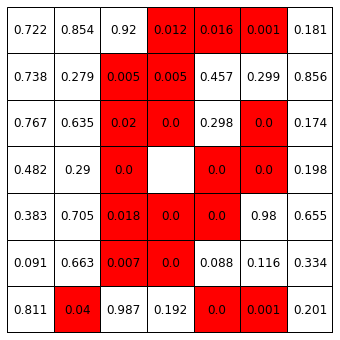

In [ ]:
rep = 0
numbers = np.arange(1, 50).reshape(7, 7)

fig, ax = plt.subplots(figsize=(6, 6))

for row in range(7):
    for col in range(7):
        rect = plt.Rectangle((6 - col, row), 1, 1, edgecolor='black', facecolor='white')
        if(row == 3 and col == 3):
            continue
        sig = significance_OLS_plane[row, col, rep]  ### Change to different method by referring to different data
        #sig = significance_fast_plane[row, col, rep]
        #sig = significance_lev_plane[row, col, rep]
        #sig = significance_random_plane[row, col, rep]

        if(sig < 0.05):
            rect = plt.Rectangle((6 - col, row), 1, 1, edgecolor='black', facecolor='red')
        ax.add_patch(rect)
        ax.text(6 - col + 0.5, row + 0.5, str(round(sig,3)),
                ha='center', va='center', fontsize=12)


ax.plot([7, 7], [0, 7], color='black', lw=2)
ax.plot([0, 7], [0, 0], color='black', lw=2)

ax.set_xlim(0, 7)
ax.set_ylim(0, 7)
ax.set_aspect('equal')
ax.axis('off')  

plt.show()